In [2]:
!pip install plot_keras_history

  Running setup.py install for compress-json: started
    Running setup.py install for compress-json: finished with status 'done'
  Running setup.py install for sanitize-ml-labels: started
    Running setup.py install for sanitize-ml-labels: finished with status 'done'
  Running setup.py install for plot-keras-history: started
    Running setup.py install for plot-keras-history: finished with status 'done'


In [4]:
!pip install tensorflow==2.1.0

tensorboard 2.1.1 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.


  Using cached https://files.pythonhosted.org/packages/8a/48/a76be51647d0eb9f10e2a4511bf3ffb8cc1e6b14e9e4fab46173aa79f981/termcolor-1.1.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/d9/41/bbf49b61370e4f4d245d4c6051dfb6db80cec672605c91b1652ac8cc3d38/tensorboard-2.1.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4e/35/11749bf99b2d4e3cceb4d55ca22590b0d7c2c62b9de38ac4a4a7f4687421/gast-0.2.2.tar.gz
  Using cached https://files.pythonhosted.org/packages/82/f7/e43cefbe88c5fd371f4cf0cf5eb3feccd07515af9fd6cf7dbf1d1793a797/wrapt-1.12.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/18/90/b77c328a1304437ab1310b463e533fa7689f4bfc41549593056d812fab8e/tensorflow_estimator-2.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a3/de/c648ef6835192e6e2cc03f40b19eeda4382c49b5bafb43d88b931c4c74ac/google_pasta-0.2.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c3/88/97eef84f48fa04fbd6750e62dcc

In [3]:
!pip install keras==2.3.1

  Using cached https://files.pythonhosted.org/packages/ad/fd/6bfe87920d7f4fd475acd28500a42482b6b84479832bdc0fe9e589a60ceb/Keras-2.3.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0b/fa/bee65d2dbdbd3611702aafd128139c53c90a1285f169ba5467aab252e27a/h5py-2.10.0-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/79/4c/7c3275a01e12ef9368a892926ab932b33bb13d55794881e3573482b378a7/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl


In [5]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 15 21:39:26 2020

@author: isswan
"""
from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import pandas as pd
from keras.preprocessing.text import Tokenizer, one_hot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from plot_keras_history import plot_history


Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

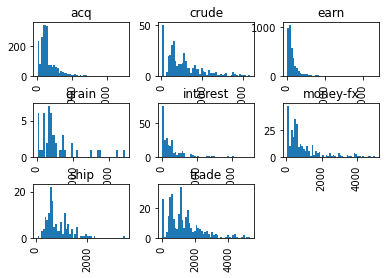

<Figure size 432x288 with 0 Axes>

In [7]:
#Data Preparation
import pandas as pd
news=pd.read_table('r8-full-data.txt',header=None,names = ["Class", "Text"])
news.head()
a = news.groupby("Class")
a.head()
a.describe()
y=news['Class']
X=news['Text']

##check the length to determine the document length for DNN

length=news['Text'].apply(len)
news=news.assign(Length=length)

#Plot the distribution of the document length for each category
import matplotlib.pyplot as plt
news.hist(column='Length',by='Class',bins=50)

plt.figure()

In [9]:
#Data Preprocessing 

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

#fixed length for improved efficiency
MAX_LEN=100 
maxlen=MAX_LEN

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

vocabubary size: 19998
max length text: 964
0.848034803480348


In [10]:
#create class weight dict for unbanlanced dataset
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))

##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot.shape
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot.shape

c:\users\guofe\workspace\nus_term4\venv\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=['acq' 'crude' 'earn' 'grain' 'interest' 'money-fx' 'ship' 'trade'], y=3759    ship
2907    ship
4935    earn
1396    earn
931      acq
        ... 
905      acq
5192    earn
3980    earn
235     earn
5157    earn
Name: Class, Length: 5371, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(2303, 8)

In [8]:
#Define the BiLSTM model with output Dropout
##############################################
model_out_dp = Sequential()
model_out_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model_out_dp.add(Bidirectional(LSTM(64)))
#output Dropout
model_out_dp.add(Dropout(0.5))
model_out_dp.add(Dense(8, activation='softmax'))

# try using different optimizers and different optimizer configs
model_out_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_out_dp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/5
5371/5371 [==============================] - 20s 4ms/step - loss: 0.9332 - accuracy: 0.6978 - val_loss: 0.5168 - val_accuracy: 0.8241
Epoch 2/5
5371/5371 [==============================] - 18s 3ms/step - loss: 0.5448 - accuracy: 0.8175 - val_loss: 0.4969 - val_accuracy: 0.8532
Epoch 3/5
5371/5371 [==============================] - 18s 3ms/step - loss: 0.4207 - accuracy: 0.8568 - val_loss: 0.3640 - val_accuracy: 0.8732
Epoch 4/5
5371/5371 [==============================] - 18s 3ms/step - loss: 0.3426 - accuracy: 0.8855 - val_loss: 0.3321 - val_accuracy: 0.8810
Epoch 5/5
5371/5371 [==============================] - 9s 2ms/step
Training Accuracy: 0.9274
Testing Accuracy:  0.9079


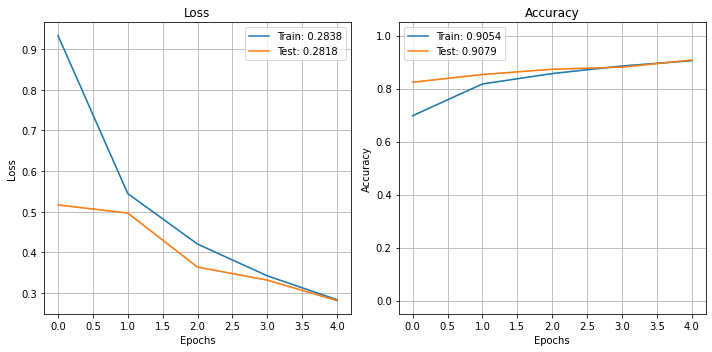

In [9]:
#Train the model
batch_size = 64

print('Train...')
hist_out_dp = model_out_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_out_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_out_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_out_dp)

In [10]:
print(hist_out_dp)

{'val_loss': [0.5168388883704161, 0.4969146307193865, 0.3640436992741542, 0.3320605911628298, 0.28178203151542314], 'val_accuracy': [0.8241423964500427, 0.8532348871231079, 0.8732088804244995, 0.8810247778892517, 0.9079461693763733], 'loss': [0.9331862941686723, 0.5447538633005643, 0.42065257663013017, 0.34262708551367443, 0.2837537286435175], 'accuracy': [0.6978216, 0.8175386, 0.8568237, 0.8854962, 0.905418]}


In [11]:
#Input Layer Dropout. 
###############################################################################
model_input_dp = Sequential()
model_input_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout
model_input_dp.add(Bidirectional(LSTM(64,dropout=0.5)))
model_input_dp.add(Dense(8, activation='softmax'))
# try using different optimizers and different optimizer configs
model_input_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_input_dp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/5
5371/5371 [==============================] - 19s 4ms/step - loss: 1.0868 - accuracy: 0.6388 - val_loss: 0.6820 - val_accuracy: 0.7464
Epoch 2/5
5371/5371 [==============================] - 18s 3ms/step - loss: 0.6310 - accuracy: 0.7771 - val_loss: 0.5114 - val_accuracy: 0.8194
Epoch 3/5
5371/5371 [==============================] - 18s 3ms/step - loss: 0.5393 - accuracy: 0.8079 - val_loss: 0.4049 - val_accuracy: 0.8602
Epoch 4/5
5371/5371 [==============================] - 18s 3ms/step - loss: 0.4505 - accuracy: 0.8460 - val_loss: 0.3464 - val_accuracy: 0.8745
Epoch 5/5
5371/5371 [==============================] - 9s 2ms/step
Training Accuracy: 0.8985
Testing Accuracy:  0.8832


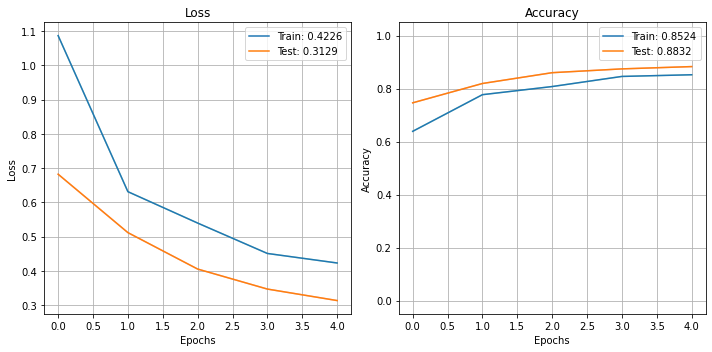

In [12]:
#Train the model
batch_size = 64

print('Train...')
hist_input_dp = model_input_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_input_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_input_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_input_dp)

In [13]:
#recurent_dropout
###############################################################################
model_rec_dp = Sequential()
model_rec_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#recurent_dropout
model_rec_dp.add(Bidirectional(LSTM(64,recurrent_dropout=0.5)))
model_rec_dp.add(Dense(8, activation='softmax'))

# try using different optimizers and different optimizer configs
model_rec_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_rec_dp.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/5
5371/5371 [==============================] - 20s 4ms/step - loss: 1.0228 - accuracy: 0.6513 - val_loss: 0.5503 - val_accuracy: 0.8020
Epoch 2/5
5371/5371 [==============================] - 19s 3ms/step - loss: 0.5728 - accuracy: 0.8064 - val_loss: 0.4457 - val_accuracy: 0.8524
Epoch 3/5
5371/5371 [==============================] - 19s 3ms/step - loss: 0.4511 - accuracy: 0.8527 - val_loss: 0.3711 - val_accuracy: 0.8736
Epoch 4/5
5371/5371 [==============================] - 19s 3ms/step - loss: 0.3647 - accuracy: 0.8743 - val_loss: 0.3284 - val_accuracy: 0.8836
Epoch 5/5
5371/5371 [==============================] - 9s 2ms/step
Training Accuracy: 0.9185
Testing Accuracy:  0.8962


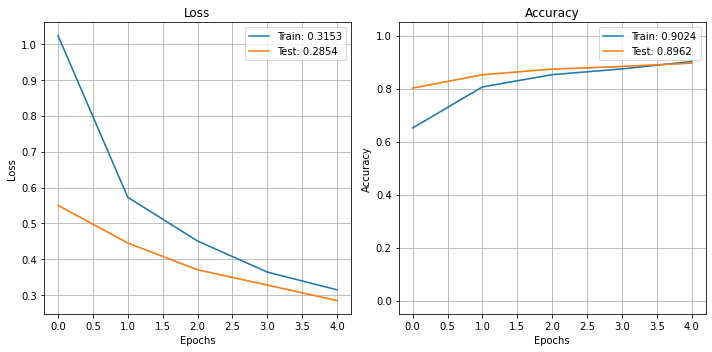

In [14]:
#Train the model
batch_size = 64

print('Train...')
hist_rec_dp = model_rec_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_rec_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_rec_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_rec_dp)

In [15]:
#Combain all dropout
##############################################################################
model_all_dp = Sequential()
model_all_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout and rec Dropout
model_all_dp.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
#output Dropout
model_all_dp.add(Dropout(0.5))
model_all_dp.add(Dense(8, activation='softmax'))
# try using different optimizers and different optimizer configs
model_all_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_all_dp.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/5
5371/5371 [==============================] - 20s 4ms/step - loss: 1.2899 - accuracy: 0.5651 - val_loss: 0.8493 - val_accuracy: 0.6943
Epoch 2/5
5371/5371 [==============================] - 19s 4ms/step - loss: 0.8385 - accuracy: 0.7153 - val_loss: 0.6483 - val_accuracy: 0.7586
Epoch 3/5
5371/5371 [==============================] - 19s 4ms/step - loss: 0.7206 - accuracy: 0.7494 - val_loss: 0.5429 - val_accuracy: 0.8055
Epoch 4/5
5371/5371 [==============================] - 19s 3ms/step - loss: 0.6480 - accuracy: 0.7773 - val_loss: 0.4473 - val_accuracy: 0.8428
Epoch 5/5
5371/5371 [==============================] - 9s 2ms/step
Training Accuracy: 0.8669
Testing Accuracy:  0.8576


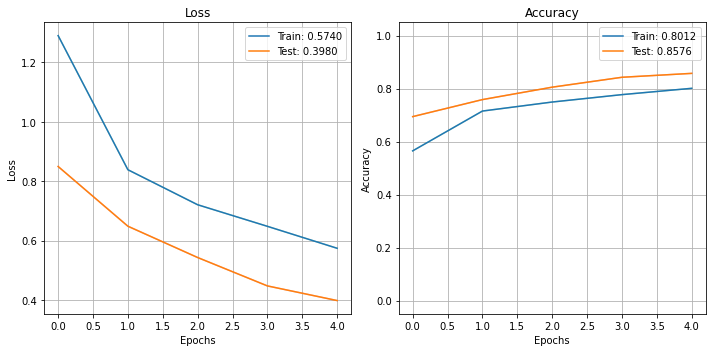

In [16]:
#Train the model
batch_size = 64

print('Train...')
hist_all_dp = model_all_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_all_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_all_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_all_dp)

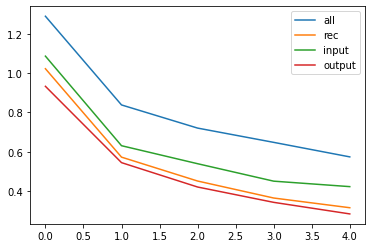

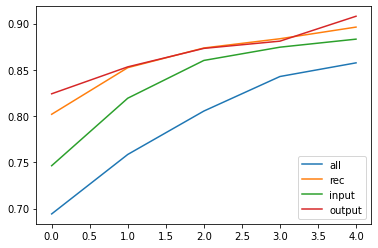

In [17]:
#Compare all the models

plt.plot(hist_all_dp['loss'], label='all')
plt.plot(hist_rec_dp['loss'], label='rec')
plt.plot(hist_input_dp['loss'], label='input')
plt.plot(hist_out_dp['loss'], label='output')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist_all_dp['val_accuracy'], label='all')
plt.plot(hist_rec_dp['val_accuracy'], label='rec')
plt.plot(hist_input_dp['val_accuracy'], label='input')
plt.plot(hist_out_dp['val_accuracy'], label='output')
plt.legend(loc='lower right')
plt.show()
